# Chapter 3.6 - Predicting hourse prices - The Boston Hourse Price dataset

In [1]:
from keras.datasets import boston_housing

Using TensorFlow backend.


In [2]:
(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

In [3]:
train_data.shape

(404, 13)

In [4]:
test_data.shape

(102, 13)

In [5]:
train_targets.shape

(404,)

In [6]:
train_targets

array([ 15.2,  42.3,  50. ,  21.1,  17.7,  18.5,  11.3,  15.6,  15.6,
        14.4,  12.1,  17.9,  23.1,  19.9,  15.7,   8.8,  50. ,  22.5,
        24.1,  27.5,  10.9,  30.8,  32.9,  24. ,  18.5,  13.3,  22.9,
        34.7,  16.6,  17.5,  22.3,  16.1,  14.9,  23.1,  34.9,  25. ,
        13.9,  13.1,  20.4,  20. ,  15.2,  24.7,  22.2,  16.7,  12.7,
        15.6,  18.4,  21. ,  30.1,  15.1,  18.7,   9.6,  31.5,  24.8,
        19.1,  22. ,  14.5,  11. ,  32. ,  29.4,  20.3,  24.4,  14.6,
        19.5,  14.1,  14.3,  15.6,  10.5,   6.3,  19.3,  19.3,  13.4,
        36.4,  17.8,  13.5,  16.5,   8.3,  14.3,  16. ,  13.4,  28.6,
        43.5,  20.2,  22. ,  23. ,  20.7,  12.5,  48.5,  14.6,  13.4,
        23.7,  50. ,  21.7,  39.8,  38.7,  22.2,  34.9,  22.5,  31.1,
        28.7,  46. ,  41.7,  21. ,  26.6,  15. ,  24.4,  13.3,  21.2,
        11.7,  21.7,  19.4,  50. ,  22.8,  19.7,  24.7,  36.2,  14.2,
        18.9,  18.3,  20.6,  24.6,  18.2,   8.7,  44. ,  10.4,  13.2,
        21.2,  37. ,

## Preparing the data

### Normalizing the data

In [7]:
# Calculating the mean value of the training set (along the first axis (index = 0)).
mean = train_data.mean(axis = 0)

In [8]:
# Substracting that mean from the training data in order to center that around 0.
train_data -= mean

In [9]:
# Calculating the Standard Deviation of the training set
std = train_data.std(axis = 0)

In [10]:
print('Min: ', train_data.min())
print('Max: ', train_data.max())

Min:  -354.463168317
Max:  305.101485149


In [11]:
# Dividing the dataset by STD
train_data /= std

In [12]:
print('Min: ', train_data.min())
print('Max: ', train_data.max())

Min:  -3.81725032019
Max:  9.2348471784


In [13]:
# Substracting training mean value from the test dataset and dividing it by the STD
test_data -= mean
test_data /= std

In [14]:
print('Min: ', test_data.min())
print('Max: ', test_data.max())

Min:  -3.51225669583
Max:  4.13583229471


## Building the network

In [15]:
from keras.models import Sequential
from keras.layers import Dense

In [16]:
# Constructing a function
def build_model():
    model = Sequential()
    model.add(Dense(units = 64, 
                    activation = 'relu', 
                    input_shape = (train_data.shape[1],)))
    model.add(Dense(units = 64, 
                    activation = 'relu'))
    model.add(Dense(units = 1))
    model.compile(optimizer = 'rmsprop', 
                  loss = 'mse',
                  metrics = ['mae'])
    return model

## K-fold validation

In [17]:
import numpy as np

In [18]:
# Defining number of folds
k = 4

In [19]:
num_val_samples = len(train_data) // k
num_epochs = 100
all_scores = []

In [20]:
for i in range(k):
    print('Processing fold #', i)
    # Prepare the validation data: data from partition # k
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]

    # Prepare the training data: data from all other partitions
    partial_train_data = np.concatenate([train_data[:i * num_val_samples],
                                         train_data[(i + 1) * num_val_samples:]],
                                         axis = 0)
    partial_train_targets = np.concatenate([train_targets[:i * num_val_samples],
                                            train_targets[(i + 1) * num_val_samples:]],
                                            axis = 0)

    # Build the Keras model (already compiled)
    model = build_model()
    # Train the model (in silent mode, verbose = 0)
    model.fit(partial_train_data, 
              partial_train_targets,
              epochs = num_epochs, 
              batch_size = 1, 
              verbose = 0)
    # Evaluate the model on the validation data
    val_mse, val_mae = model.evaluate(val_data, 
                                      val_targets, 
                                      verbose = 0)
    all_scores.append(val_mae)

Processing fold # 0
Processing fold # 1
Processing fold # 2
Processing fold # 3


In [21]:
all_scores

[2.0795102272883499,
 2.1256098487589621,
 2.9143614910616735,
 2.4292112671502748]

In [22]:
np.mean(all_scores)

2.387173208564815

## Saving the validation logs at each fold

In [23]:
from keras import backend as K

# Some memory clean-up
K.clear_session()

In [24]:
num_epochs = 500
all_mae_histories = []
for i in range(k):
    print('Processing fold #', i)
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
    partial_train_data = np.concatenate([train_data[:i * num_val_samples],
                                         train_data[(i + 1) * num_val_samples:]],
                                         axis = 0)
    
    partial_train_targets = np.concatenate([train_targets[:i * num_val_samples],
                                            train_targets[(i + 1) * num_val_samples:]],
                                            axis = 0)
    model = build_model()
    history = model.fit(x = partial_train_data, 
                        y = partial_train_targets,
                        validation_data = (val_data, val_targets),
                        epochs = num_epochs, 
                        batch_size = 1, 
                        verbose = 1)
    mae_history = history.history['val_mean_absolute_error']
    all_mae_histories.append(mae_history)

Processing fold # 0
Train on 303 samples, validate on 101 samples
Epoch 1/500
303/303 [==============================] - 1s - loss: 172.3063 - mean_absolute_error: 9.9995 - val_loss: 30.3668 - val_mean_absolute_error: 3.8352
Epoch 2/500
303/303 [==============================] - 1s - loss: 26.5979 - mean_absolute_error: 3.5060 - val_loss: 20.3579 - val_mean_absolute_error: 2.7898
Epoch 3/500
303/303 [==============================] - 1s - loss: 19.3642 - mean_absolute_error: 2.8775 - val_loss: 17.4801 - val_mean_absolute_error: 2.5965
Epoch 4/500
303/303 [==============================] - 1s - loss: 17.6777 - mean_absolute_error: 2.7136 - val_loss: 14.9171 - val_mean_absolute_error: 2.3453
Epoch 5/500
303/303 [==============================] - 1s - loss: 16.0331 - mean_absolute_error: 2.6369 - val_loss: 15.0310 - val_mean_absolute_error: 2.4165
Epoch 6/500
303/303 [==============================] - 1s - loss: 14.7644 - mean_absolute_error: 2.5501 - val_loss: 12.1065 - val_mean_absolute

303/303 [==============================] - 1s - loss: 6.7143 - mean_absolute_error: 1.7520 - val_loss: 10.4186 - val_mean_absolute_error: 2.0619
Epoch 53/500
303/303 [==============================] - 1s - loss: 6.5718 - mean_absolute_error: 1.7197 - val_loss: 12.1191 - val_mean_absolute_error: 2.6431
Epoch 54/500
303/303 [==============================] - 1s - loss: 6.5487 - mean_absolute_error: 1.7036 - val_loss: 10.6085 - val_mean_absolute_error: 2.2883
Epoch 55/500
303/303 [==============================] - 1s - loss: 6.7015 - mean_absolute_error: 1.7237 - val_loss: 7.6493 - val_mean_absolute_error: 1.8086
Epoch 56/500
303/303 [==============================] - 1s - loss: 6.4147 - mean_absolute_error: 1.6573 - val_loss: 8.7782 - val_mean_absolute_error: 1.9038
Epoch 57/500
303/303 [==============================] - 1s - loss: 5.7702 - mean_absolute_error: 1.6313 - val_loss: 8.6770 - val_mean_absolute_error: 1.9336
Epoch 58/500
303/303 [==============================] - 1s - loss: 6

303/303 [==============================] - 1s - loss: 4.4034 - mean_absolute_error: 1.4190 - val_loss: 8.3746 - val_mean_absolute_error: 2.0067
Epoch 105/500
303/303 [==============================] - 1s - loss: 3.8879 - mean_absolute_error: 1.3392 - val_loss: 11.8292 - val_mean_absolute_error: 2.3639
Epoch 106/500
303/303 [==============================] - 1s - loss: 4.2598 - mean_absolute_error: 1.4291 - val_loss: 8.9471 - val_mean_absolute_error: 2.1262
Epoch 107/500
303/303 [==============================] - 1s - loss: 4.1927 - mean_absolute_error: 1.3517 - val_loss: 8.6936 - val_mean_absolute_error: 2.0677
Epoch 108/500
303/303 [==============================] - 1s - loss: 3.7570 - mean_absolute_error: 1.3405 - val_loss: 11.4134 - val_mean_absolute_error: 2.2847
Epoch 109/500
303/303 [==============================] - 1s - loss: 4.1914 - mean_absolute_error: 1.3556 - val_loss: 9.5852 - val_mean_absolute_error: 2.1628
Epoch 110/500
303/303 [==============================] - 1s - lo

303/303 [==============================] - 1s - loss: 2.8936 - mean_absolute_error: 1.1936 - val_loss: 10.7382 - val_mean_absolute_error: 2.2787
Epoch 156/500
303/303 [==============================] - 1s - loss: 2.7758 - mean_absolute_error: 1.2051 - val_loss: 11.5448 - val_mean_absolute_error: 2.4128
Epoch 157/500
303/303 [==============================] - 1s - loss: 2.7386 - mean_absolute_error: 1.1998 - val_loss: 11.2674 - val_mean_absolute_error: 2.2352
Epoch 158/500
303/303 [==============================] - 1s - loss: 2.6922 - mean_absolute_error: 1.1878 - val_loss: 11.7180 - val_mean_absolute_error: 2.3971
Epoch 159/500
303/303 [==============================] - 1s - loss: 2.7735 - mean_absolute_error: 1.1575 - val_loss: 9.3780 - val_mean_absolute_error: 2.1760
Epoch 160/500
303/303 [==============================] - 1s - loss: 2.7857 - mean_absolute_error: 1.1271 - val_loss: 10.3847 - val_mean_absolute_error: 2.2329
Epoch 161/500
303/303 [==============================] - 1s -

303/303 [==============================] - 1s - loss: 1.8995 - mean_absolute_error: 1.0217 - val_loss: 15.6363 - val_mean_absolute_error: 2.6404
Epoch 207/500
303/303 [==============================] - 1s - loss: 2.2718 - mean_absolute_error: 1.0383 - val_loss: 10.4854 - val_mean_absolute_error: 2.3069
Epoch 208/500
303/303 [==============================] - 1s - loss: 1.9502 - mean_absolute_error: 1.0357 - val_loss: 11.4762 - val_mean_absolute_error: 2.2964
Epoch 209/500
303/303 [==============================] - 1s - loss: 2.1058 - mean_absolute_error: 1.0262 - val_loss: 11.9035 - val_mean_absolute_error: 2.3252
Epoch 210/500
303/303 [==============================] - 1s - loss: 2.2149 - mean_absolute_error: 1.0448 - val_loss: 10.7596 - val_mean_absolute_error: 2.3412
Epoch 211/500
303/303 [==============================] - 1s - loss: 1.9829 - mean_absolute_error: 0.9971 - val_loss: 11.7759 - val_mean_absolute_error: 2.4659
Epoch 212/500
303/303 [==============================] - 1s 

303/303 [==============================] - 1s - loss: 1.7330 - mean_absolute_error: 0.9462 - val_loss: 14.6402 - val_mean_absolute_error: 2.4872
Epoch 258/500
303/303 [==============================] - 1s - loss: 1.4243 - mean_absolute_error: 0.9022 - val_loss: 12.1964 - val_mean_absolute_error: 2.5392
Epoch 259/500
303/303 [==============================] - 1s - loss: 1.6026 - mean_absolute_error: 0.9159 - val_loss: 12.9358 - val_mean_absolute_error: 2.4563
Epoch 260/500
303/303 [==============================] - 1s - loss: 1.9812 - mean_absolute_error: 0.9494 - val_loss: 12.7155 - val_mean_absolute_error: 2.3685
Epoch 261/500
303/303 [==============================] - 1s - loss: 1.6350 - mean_absolute_error: 0.8874 - val_loss: 11.2853 - val_mean_absolute_error: 2.4088
Epoch 262/500
303/303 [==============================] - 1s - loss: 1.9064 - mean_absolute_error: 0.9718 - val_loss: 12.9013 - val_mean_absolute_error: 2.4341
Epoch 263/500
303/303 [==============================] - 1s 

303/303 [==============================] - 1s - loss: 1.2972 - mean_absolute_error: 0.8539 - val_loss: 11.3461 - val_mean_absolute_error: 2.4037
Epoch 309/500
303/303 [==============================] - 1s - loss: 1.4317 - mean_absolute_error: 0.8661 - val_loss: 12.7405 - val_mean_absolute_error: 2.4138
Epoch 310/500
303/303 [==============================] - 1s - loss: 1.3793 - mean_absolute_error: 0.8320 - val_loss: 13.2074 - val_mean_absolute_error: 2.5523
Epoch 311/500
303/303 [==============================] - 1s - loss: 1.3092 - mean_absolute_error: 0.8253 - val_loss: 12.5780 - val_mean_absolute_error: 2.4095
Epoch 312/500
303/303 [==============================] - 1s - loss: 1.3023 - mean_absolute_error: 0.8099 - val_loss: 12.7019 - val_mean_absolute_error: 2.3676
Epoch 313/500
303/303 [==============================] - 1s - loss: 1.3985 - mean_absolute_error: 0.8346 - val_loss: 12.9617 - val_mean_absolute_error: 2.4451
Epoch 314/500
303/303 [==============================] - 1s 

303/303 [==============================] - 1s - loss: 1.2049 - mean_absolute_error: 0.8214 - val_loss: 12.8798 - val_mean_absolute_error: 2.6035
Epoch 360/500
303/303 [==============================] - 1s - loss: 1.1754 - mean_absolute_error: 0.7906 - val_loss: 11.8629 - val_mean_absolute_error: 2.4015
Epoch 361/500
303/303 [==============================] - 1s - loss: 1.2951 - mean_absolute_error: 0.8395 - val_loss: 12.0335 - val_mean_absolute_error: 2.4136
Epoch 362/500
303/303 [==============================] - 1s - loss: 1.1308 - mean_absolute_error: 0.7661 - val_loss: 11.5225 - val_mean_absolute_error: 2.3366
Epoch 363/500
303/303 [==============================] - 1s - loss: 1.2839 - mean_absolute_error: 0.8136 - val_loss: 13.1565 - val_mean_absolute_error: 2.5625
Epoch 364/500
303/303 [==============================] - 2s - loss: 1.2778 - mean_absolute_error: 0.7396 - val_loss: 11.4581 - val_mean_absolute_error: 2.3075
Epoch 365/500
303/303 [==============================] - 1s 

303/303 [==============================] - 1s - loss: 1.1657 - mean_absolute_error: 0.7432 - val_loss: 12.3282 - val_mean_absolute_error: 2.3691
Epoch 411/500
303/303 [==============================] - 1s - loss: 1.1043 - mean_absolute_error: 0.7769 - val_loss: 10.8674 - val_mean_absolute_error: 2.4647
Epoch 412/500
303/303 [==============================] - 1s - loss: 1.0783 - mean_absolute_error: 0.7261 - val_loss: 11.4156 - val_mean_absolute_error: 2.3925
Epoch 413/500
303/303 [==============================] - 1s - loss: 1.1192 - mean_absolute_error: 0.7656 - val_loss: 14.2492 - val_mean_absolute_error: 2.6419
Epoch 414/500
303/303 [==============================] - 1s - loss: 0.9779 - mean_absolute_error: 0.7008 - val_loss: 11.7434 - val_mean_absolute_error: 2.3989
Epoch 415/500
303/303 [==============================] - 1s - loss: 1.1354 - mean_absolute_error: 0.7400 - val_loss: 12.5330 - val_mean_absolute_error: 2.4638
Epoch 416/500
303/303 [==============================] - 1s 

303/303 [==============================] - 1s - loss: 0.9993 - mean_absolute_error: 0.7090 - val_loss: 11.4201 - val_mean_absolute_error: 2.3661
Epoch 462/500
303/303 [==============================] - 1s - loss: 1.1453 - mean_absolute_error: 0.7140 - val_loss: 11.4917 - val_mean_absolute_error: 2.4275
Epoch 463/500
303/303 [==============================] - 1s - loss: 0.8444 - mean_absolute_error: 0.6461 - val_loss: 11.4388 - val_mean_absolute_error: 2.4118
Epoch 464/500
303/303 [==============================] - 1s - loss: 0.9938 - mean_absolute_error: 0.6907 - val_loss: 14.5728 - val_mean_absolute_error: 2.6694
Epoch 465/500
303/303 [==============================] - 1s - loss: 1.0198 - mean_absolute_error: 0.7441 - val_loss: 11.8742 - val_mean_absolute_error: 2.4374
Epoch 466/500
303/303 [==============================] - 1s - loss: 0.9476 - mean_absolute_error: 0.6985 - val_loss: 12.0424 - val_mean_absolute_error: 2.3289
Epoch 467/500
303/303 [==============================] - 1s 

303/303 [==============================] - 2s - loss: 11.1241 - mean_absolute_error: 2.1462 - val_loss: 11.0078 - val_mean_absolute_error: 2.5433
Epoch 12/500
303/303 [==============================] - 1s - loss: 10.5458 - mean_absolute_error: 2.1097 - val_loss: 13.7119 - val_mean_absolute_error: 2.8906
Epoch 13/500
303/303 [==============================] - 1s - loss: 10.2912 - mean_absolute_error: 2.0861 - val_loss: 11.5024 - val_mean_absolute_error: 2.6665
Epoch 14/500
303/303 [==============================] - 1s - loss: 9.6133 - mean_absolute_error: 2.1363 - val_loss: 10.6686 - val_mean_absolute_error: 2.5773
Epoch 15/500
303/303 [==============================] - 1s - loss: 9.6539 - mean_absolute_error: 2.0743 - val_loss: 10.1907 - val_mean_absolute_error: 2.4661
Epoch 16/500
303/303 [==============================] - 1s - loss: 9.6703 - mean_absolute_error: 2.0663 - val_loss: 10.7612 - val_mean_absolute_error: 2.5168
Epoch 17/500
303/303 [==============================] - 1s - l

303/303 [==============================] - 1s - loss: 4.4054 - mean_absolute_error: 1.4299 - val_loss: 9.7262 - val_mean_absolute_error: 2.3107
Epoch 64/500
303/303 [==============================] - 1s - loss: 4.7890 - mean_absolute_error: 1.5261 - val_loss: 9.4942 - val_mean_absolute_error: 2.2798
Epoch 65/500
303/303 [==============================] - 1s - loss: 4.5307 - mean_absolute_error: 1.4766 - val_loss: 10.5618 - val_mean_absolute_error: 2.3540
Epoch 66/500
303/303 [==============================] - 1s - loss: 4.4991 - mean_absolute_error: 1.4706 - val_loss: 10.2598 - val_mean_absolute_error: 2.3903
Epoch 67/500
303/303 [==============================] - 1s - loss: 4.9892 - mean_absolute_error: 1.4960 - val_loss: 10.3579 - val_mean_absolute_error: 2.3673
Epoch 68/500
303/303 [==============================] - 1s - loss: 4.8300 - mean_absolute_error: 1.4582 - val_loss: 10.1035 - val_mean_absolute_error: 2.2394
Epoch 69/500
303/303 [==============================] - 1s - loss: 

303/303 [==============================] - 2s - loss: 3.2388 - mean_absolute_error: 1.2186 - val_loss: 16.9029 - val_mean_absolute_error: 2.5037
Epoch 115/500
303/303 [==============================] - 2s - loss: 2.8804 - mean_absolute_error: 1.1921 - val_loss: 18.9459 - val_mean_absolute_error: 2.8018
Epoch 116/500
303/303 [==============================] - 1s - loss: 3.0837 - mean_absolute_error: 1.2698 - val_loss: 15.1499 - val_mean_absolute_error: 2.5700
Epoch 117/500
303/303 [==============================] - 2s - loss: 2.8845 - mean_absolute_error: 1.1920 - val_loss: 16.1370 - val_mean_absolute_error: 2.4852
Epoch 118/500
303/303 [==============================] - 2s - loss: 3.0003 - mean_absolute_error: 1.1581 - val_loss: 16.4241 - val_mean_absolute_error: 2.7047
Epoch 119/500
303/303 [==============================] - 2s - loss: 2.8548 - mean_absolute_error: 1.1517 - val_loss: 21.3915 - val_mean_absolute_error: 2.9476
Epoch 120/500
303/303 [==============================] - 1s 

303/303 [==============================] - 1s - loss: 2.0359 - mean_absolute_error: 1.0026 - val_loss: 20.4194 - val_mean_absolute_error: 2.8881
Epoch 166/500
303/303 [==============================] - 1s - loss: 2.0293 - mean_absolute_error: 1.0350 - val_loss: 25.0242 - val_mean_absolute_error: 2.9679
Epoch 167/500
303/303 [==============================] - 1s - loss: 2.0440 - mean_absolute_error: 1.0445 - val_loss: 16.1775 - val_mean_absolute_error: 2.7861
Epoch 168/500
303/303 [==============================] - 1s - loss: 2.2060 - mean_absolute_error: 1.1098 - val_loss: 15.9470 - val_mean_absolute_error: 2.6322
Epoch 169/500
303/303 [==============================] - 1s - loss: 2.1750 - mean_absolute_error: 1.0976 - val_loss: 20.2463 - val_mean_absolute_error: 2.8529
Epoch 170/500
303/303 [==============================] - 1s - loss: 2.1435 - mean_absolute_error: 1.0708 - val_loss: 20.6043 - val_mean_absolute_error: 2.7812
Epoch 171/500
303/303 [==============================] - 1s 

303/303 [==============================] - 1s - loss: 1.4962 - mean_absolute_error: 0.9012 - val_loss: 18.7770 - val_mean_absolute_error: 2.9618
Epoch 217/500
303/303 [==============================] - 1s - loss: 1.6027 - mean_absolute_error: 0.9566 - val_loss: 19.4428 - val_mean_absolute_error: 3.0120
Epoch 218/500
303/303 [==============================] - 1s - loss: 1.3845 - mean_absolute_error: 0.8955 - val_loss: 16.3041 - val_mean_absolute_error: 3.0569
Epoch 219/500
303/303 [==============================] - 1s - loss: 1.7018 - mean_absolute_error: 0.9495 - val_loss: 17.0630 - val_mean_absolute_error: 2.9277
Epoch 220/500
303/303 [==============================] - 1s - loss: 1.4051 - mean_absolute_error: 0.8781 - val_loss: 18.3989 - val_mean_absolute_error: 2.9209
Epoch 221/500
303/303 [==============================] - 1s - loss: 1.5183 - mean_absolute_error: 0.8951 - val_loss: 18.8446 - val_mean_absolute_error: 3.0537
Epoch 222/500
303/303 [==============================] - 1s 

303/303 [==============================] - 1s - loss: 1.3617 - mean_absolute_error: 0.8441 - val_loss: 16.7282 - val_mean_absolute_error: 2.6463
Epoch 268/500
303/303 [==============================] - 1s - loss: 1.2263 - mean_absolute_error: 0.8455 - val_loss: 20.1911 - val_mean_absolute_error: 2.9589
Epoch 269/500
303/303 [==============================] - 1s - loss: 1.1543 - mean_absolute_error: 0.8110 - val_loss: 14.2358 - val_mean_absolute_error: 2.6880
Epoch 270/500
303/303 [==============================] - 1s - loss: 1.2059 - mean_absolute_error: 0.8460 - val_loss: 16.2621 - val_mean_absolute_error: 2.9730
Epoch 271/500
303/303 [==============================] - 1s - loss: 1.1147 - mean_absolute_error: 0.7716 - val_loss: 20.0510 - val_mean_absolute_error: 2.8828
Epoch 272/500
303/303 [==============================] - 1s - loss: 1.2596 - mean_absolute_error: 0.8329 - val_loss: 16.0842 - val_mean_absolute_error: 2.8310
Epoch 273/500
303/303 [==============================] - 1s 

303/303 [==============================] - 1s - loss: 1.1595 - mean_absolute_error: 0.8020 - val_loss: 21.2122 - val_mean_absolute_error: 2.9537
Epoch 319/500
303/303 [==============================] - 1s - loss: 1.0477 - mean_absolute_error: 0.7351 - val_loss: 24.4544 - val_mean_absolute_error: 3.0718
Epoch 320/500
303/303 [==============================] - 1s - loss: 1.0995 - mean_absolute_error: 0.7728 - val_loss: 14.1109 - val_mean_absolute_error: 2.5368
Epoch 321/500
303/303 [==============================] - 1s - loss: 1.0644 - mean_absolute_error: 0.7454 - val_loss: 22.8110 - val_mean_absolute_error: 3.0321
Epoch 322/500
303/303 [==============================] - 1s - loss: 1.1585 - mean_absolute_error: 0.7864 - val_loss: 17.7675 - val_mean_absolute_error: 2.7841
Epoch 323/500
303/303 [==============================] - 1s - loss: 1.1070 - mean_absolute_error: 0.7731 - val_loss: 16.5491 - val_mean_absolute_error: 2.7318
Epoch 324/500
303/303 [==============================] - 2s 

303/303 [==============================] - 2s - loss: 0.9434 - mean_absolute_error: 0.7027 - val_loss: 21.3902 - val_mean_absolute_error: 3.0235
Epoch 370/500
303/303 [==============================] - 1s - loss: 0.9107 - mean_absolute_error: 0.7112 - val_loss: 20.1680 - val_mean_absolute_error: 3.0700
Epoch 371/500
303/303 [==============================] - 1s - loss: 0.9691 - mean_absolute_error: 0.7242 - val_loss: 27.4316 - val_mean_absolute_error: 3.1645
Epoch 372/500
303/303 [==============================] - 2s - loss: 0.8478 - mean_absolute_error: 0.6867 - val_loss: 20.1739 - val_mean_absolute_error: 2.9761
Epoch 373/500
303/303 [==============================] - 1s - loss: 0.8174 - mean_absolute_error: 0.6873 - val_loss: 18.4748 - val_mean_absolute_error: 2.8639
Epoch 374/500
303/303 [==============================] - 1s - loss: 0.9228 - mean_absolute_error: 0.7092 - val_loss: 17.4215 - val_mean_absolute_error: 2.8890
Epoch 375/500
303/303 [==============================] - 1s 

303/303 [==============================] - 2s - loss: 0.8792 - mean_absolute_error: 0.6919 - val_loss: 25.9925 - val_mean_absolute_error: 3.1116
Epoch 421/500
303/303 [==============================] - 2s - loss: 0.8029 - mean_absolute_error: 0.6824 - val_loss: 23.2362 - val_mean_absolute_error: 3.0868
Epoch 422/500
303/303 [==============================] - 1s - loss: 0.9787 - mean_absolute_error: 0.7121 - val_loss: 22.7222 - val_mean_absolute_error: 3.1578
Epoch 423/500
303/303 [==============================] - 1s - loss: 0.8480 - mean_absolute_error: 0.6935 - val_loss: 13.1276 - val_mean_absolute_error: 2.5786
Epoch 424/500
303/303 [==============================] - 1s - loss: 0.7610 - mean_absolute_error: 0.6556 - val_loss: 20.1157 - val_mean_absolute_error: 3.1758
Epoch 425/500
303/303 [==============================] - 1s - loss: 0.8630 - mean_absolute_error: 0.7167 - val_loss: 28.1537 - val_mean_absolute_error: 3.2577
Epoch 426/500
303/303 [==============================] - 2s 

303/303 [==============================] - 1s - loss: 0.6563 - mean_absolute_error: 0.6051 - val_loss: 16.8080 - val_mean_absolute_error: 2.8697
Epoch 472/500
303/303 [==============================] - 1s - loss: 0.7588 - mean_absolute_error: 0.6368 - val_loss: 22.8943 - val_mean_absolute_error: 3.1577
Epoch 473/500
303/303 [==============================] - 1s - loss: 0.8204 - mean_absolute_error: 0.6637 - val_loss: 20.2815 - val_mean_absolute_error: 3.0261
Epoch 474/500
303/303 [==============================] - 1s - loss: 0.8357 - mean_absolute_error: 0.6581 - val_loss: 21.3004 - val_mean_absolute_error: 2.9983
Epoch 475/500
303/303 [==============================] - 1s - loss: 0.7647 - mean_absolute_error: 0.6108 - val_loss: 17.2695 - val_mean_absolute_error: 2.8609
Epoch 476/500
303/303 [==============================] - 1s - loss: 0.7360 - mean_absolute_error: 0.6447 - val_loss: 18.3516 - val_mean_absolute_error: 2.8996
Epoch 477/500
303/303 [==============================] - 2s 

303/303 [==============================] - 1s - loss: 7.4282 - mean_absolute_error: 1.9082 - val_loss: 14.7879 - val_mean_absolute_error: 2.5728
Epoch 23/500
303/303 [==============================] - 1s - loss: 7.5167 - mean_absolute_error: 1.8983 - val_loss: 15.0185 - val_mean_absolute_error: 2.4042
Epoch 24/500
303/303 [==============================] - 1s - loss: 7.8910 - mean_absolute_error: 1.8572 - val_loss: 14.3861 - val_mean_absolute_error: 2.4471
Epoch 25/500
303/303 [==============================] - 1s - loss: 7.3904 - mean_absolute_error: 1.7983 - val_loss: 17.2429 - val_mean_absolute_error: 3.0216
Epoch 26/500
303/303 [==============================] - 1s - loss: 7.6916 - mean_absolute_error: 1.8420 - val_loss: 13.4048 - val_mean_absolute_error: 2.3945
Epoch 27/500
303/303 [==============================] - 1s - loss: 7.1917 - mean_absolute_error: 1.7665 - val_loss: 13.1394 - val_mean_absolute_error: 2.3740
Epoch 28/500
303/303 [==============================] - 1s - loss

303/303 [==============================] - 1s - loss: 4.2930 - mean_absolute_error: 1.4790 - val_loss: 13.8686 - val_mean_absolute_error: 2.5405
Epoch 74/500
303/303 [==============================] - 1s - loss: 3.9651 - mean_absolute_error: 1.4546 - val_loss: 14.1471 - val_mean_absolute_error: 2.6463
Epoch 75/500
303/303 [==============================] - 1s - loss: 4.2075 - mean_absolute_error: 1.3890 - val_loss: 14.2901 - val_mean_absolute_error: 2.5896
Epoch 76/500
303/303 [==============================] - 1s - loss: 3.9170 - mean_absolute_error: 1.3747 - val_loss: 13.8087 - val_mean_absolute_error: 2.4783
Epoch 77/500
303/303 [==============================] - 1s - loss: 4.1756 - mean_absolute_error: 1.3827 - val_loss: 15.8551 - val_mean_absolute_error: 2.6806
Epoch 78/500
303/303 [==============================] - 2s - loss: 3.9898 - mean_absolute_error: 1.4223 - val_loss: 15.2781 - val_mean_absolute_error: 2.6423
Epoch 79/500
303/303 [==============================] - 1s - loss

303/303 [==============================] - 1s - loss: 2.7972 - mean_absolute_error: 1.1571 - val_loss: 15.1644 - val_mean_absolute_error: 2.6247
Epoch 125/500
303/303 [==============================] - 1s - loss: 2.6205 - mean_absolute_error: 1.1691 - val_loss: 15.8421 - val_mean_absolute_error: 2.7248
Epoch 126/500
303/303 [==============================] - 1s - loss: 2.8966 - mean_absolute_error: 1.1839 - val_loss: 15.2836 - val_mean_absolute_error: 2.7287
Epoch 127/500
303/303 [==============================] - 1s - loss: 2.6640 - mean_absolute_error: 1.1378 - val_loss: 16.8531 - val_mean_absolute_error: 2.8671
Epoch 128/500
303/303 [==============================] - 1s - loss: 2.9212 - mean_absolute_error: 1.2281 - val_loss: 15.0824 - val_mean_absolute_error: 2.6638
Epoch 129/500
303/303 [==============================] - 1s - loss: 2.6022 - mean_absolute_error: 1.1674 - val_loss: 17.0007 - val_mean_absolute_error: 2.8242
Epoch 130/500
303/303 [==============================] - 1s 

303/303 [==============================] - 1s - loss: 2.0110 - mean_absolute_error: 1.0303 - val_loss: 16.9476 - val_mean_absolute_error: 2.7620
Epoch 176/500
303/303 [==============================] - 1s - loss: 1.8262 - mean_absolute_error: 1.0022 - val_loss: 16.9210 - val_mean_absolute_error: 2.8948
Epoch 177/500
303/303 [==============================] - 1s - loss: 1.9302 - mean_absolute_error: 1.0188 - val_loss: 17.3240 - val_mean_absolute_error: 2.9545
Epoch 178/500
303/303 [==============================] - 1s - loss: 1.8738 - mean_absolute_error: 0.9828 - val_loss: 16.0734 - val_mean_absolute_error: 2.8796
Epoch 179/500
303/303 [==============================] - 1s - loss: 2.0365 - mean_absolute_error: 0.9900 - val_loss: 16.7630 - val_mean_absolute_error: 2.8619
Epoch 180/500
303/303 [==============================] - 1s - loss: 1.9206 - mean_absolute_error: 1.0402 - val_loss: 15.1372 - val_mean_absolute_error: 2.7238
Epoch 181/500
303/303 [==============================] - 1s 

303/303 [==============================] - 1s - loss: 1.4194 - mean_absolute_error: 0.8820 - val_loss: 16.0800 - val_mean_absolute_error: 2.7908
Epoch 227/500
303/303 [==============================] - 1s - loss: 1.4876 - mean_absolute_error: 0.8908 - val_loss: 15.7787 - val_mean_absolute_error: 2.8729
Epoch 228/500
303/303 [==============================] - 1s - loss: 1.5552 - mean_absolute_error: 0.9185 - val_loss: 16.0995 - val_mean_absolute_error: 2.7907
Epoch 229/500
303/303 [==============================] - 1s - loss: 1.4344 - mean_absolute_error: 0.8628 - val_loss: 16.6181 - val_mean_absolute_error: 2.8977
Epoch 230/500
303/303 [==============================] - 1s - loss: 1.4745 - mean_absolute_error: 0.8677 - val_loss: 15.1361 - val_mean_absolute_error: 2.6220
Epoch 231/500
303/303 [==============================] - 1s - loss: 1.3543 - mean_absolute_error: 0.8558 - val_loss: 16.3691 - val_mean_absolute_error: 2.8435
Epoch 232/500
303/303 [==============================] - 1s 

303/303 [==============================] - 1s - loss: 1.2394 - mean_absolute_error: 0.8443 - val_loss: 15.8719 - val_mean_absolute_error: 2.7938
Epoch 278/500
303/303 [==============================] - 1s - loss: 1.2303 - mean_absolute_error: 0.7924 - val_loss: 15.4864 - val_mean_absolute_error: 2.7204
Epoch 279/500
303/303 [==============================] - 1s - loss: 1.1958 - mean_absolute_error: 0.8222 - val_loss: 16.4556 - val_mean_absolute_error: 2.8397
Epoch 280/500
303/303 [==============================] - 1s - loss: 1.2791 - mean_absolute_error: 0.7708 - val_loss: 15.9358 - val_mean_absolute_error: 2.8194
Epoch 281/500
303/303 [==============================] - 1s - loss: 1.4243 - mean_absolute_error: 0.8125 - val_loss: 16.0837 - val_mean_absolute_error: 2.8952
Epoch 282/500
303/303 [==============================] - 1s - loss: 1.0334 - mean_absolute_error: 0.7436 - val_loss: 15.0466 - val_mean_absolute_error: 2.7009
Epoch 283/500
303/303 [==============================] - 1s 

303/303 [==============================] - 1s - loss: 1.2195 - mean_absolute_error: 0.7497 - val_loss: 15.4409 - val_mean_absolute_error: 2.9221
Epoch 329/500
303/303 [==============================] - 1s - loss: 1.0884 - mean_absolute_error: 0.7636 - val_loss: 15.2928 - val_mean_absolute_error: 2.8010
Epoch 330/500
303/303 [==============================] - 1s - loss: 0.9900 - mean_absolute_error: 0.7164 - val_loss: 15.6381 - val_mean_absolute_error: 2.8835
Epoch 331/500
303/303 [==============================] - 1s - loss: 0.9675 - mean_absolute_error: 0.7220 - val_loss: 15.5663 - val_mean_absolute_error: 2.8009
Epoch 332/500
303/303 [==============================] - 1s - loss: 1.0358 - mean_absolute_error: 0.7379 - val_loss: 15.1909 - val_mean_absolute_error: 2.7406
Epoch 333/500
303/303 [==============================] - 1s - loss: 1.1335 - mean_absolute_error: 0.7832 - val_loss: 16.4354 - val_mean_absolute_error: 2.9738
Epoch 334/500
303/303 [==============================] - 1s 

303/303 [==============================] - 1s - loss: 0.9532 - mean_absolute_error: 0.6896 - val_loss: 14.9378 - val_mean_absolute_error: 2.8611
Epoch 380/500
303/303 [==============================] - 1s - loss: 0.9933 - mean_absolute_error: 0.7228 - val_loss: 13.5366 - val_mean_absolute_error: 2.6354
Epoch 381/500
303/303 [==============================] - 1s - loss: 0.7989 - mean_absolute_error: 0.6743 - val_loss: 14.6098 - val_mean_absolute_error: 2.6766
Epoch 382/500
303/303 [==============================] - 1s - loss: 0.8307 - mean_absolute_error: 0.6669 - val_loss: 14.2888 - val_mean_absolute_error: 2.6701
Epoch 383/500
303/303 [==============================] - 1s - loss: 1.0425 - mean_absolute_error: 0.7368 - val_loss: 14.6091 - val_mean_absolute_error: 2.7615
Epoch 384/500
303/303 [==============================] - 1s - loss: 0.8417 - mean_absolute_error: 0.6753 - val_loss: 14.1341 - val_mean_absolute_error: 2.8159
Epoch 385/500
303/303 [==============================] - 1s 

303/303 [==============================] - 1s - loss: 0.8896 - mean_absolute_error: 0.6816 - val_loss: 13.9902 - val_mean_absolute_error: 2.6967
Epoch 431/500
303/303 [==============================] - 1s - loss: 0.8099 - mean_absolute_error: 0.6625 - val_loss: 13.9180 - val_mean_absolute_error: 2.6448
Epoch 432/500
303/303 [==============================] - 1s - loss: 0.8552 - mean_absolute_error: 0.6660 - val_loss: 16.7515 - val_mean_absolute_error: 3.0197
Epoch 433/500
303/303 [==============================] - 1s - loss: 0.8336 - mean_absolute_error: 0.6349 - val_loss: 15.1819 - val_mean_absolute_error: 2.8486
Epoch 434/500
303/303 [==============================] - 1s - loss: 0.7982 - mean_absolute_error: 0.6697 - val_loss: 15.1033 - val_mean_absolute_error: 2.8420
Epoch 435/500
303/303 [==============================] - 1s - loss: 0.9499 - mean_absolute_error: 0.6656 - val_loss: 15.3057 - val_mean_absolute_error: 2.7589
Epoch 436/500
303/303 [==============================] - 1s 

303/303 [==============================] - 1s - loss: 0.8048 - mean_absolute_error: 0.6404 - val_loss: 14.7025 - val_mean_absolute_error: 2.6901
Epoch 482/500
303/303 [==============================] - 1s - loss: 0.7541 - mean_absolute_error: 0.6368 - val_loss: 15.4020 - val_mean_absolute_error: 2.7940
Epoch 483/500
303/303 [==============================] - 1s - loss: 0.8195 - mean_absolute_error: 0.6494 - val_loss: 14.2470 - val_mean_absolute_error: 2.8013
Epoch 484/500
303/303 [==============================] - 2s - loss: 0.7791 - mean_absolute_error: 0.6391 - val_loss: 14.9694 - val_mean_absolute_error: 2.7565
Epoch 485/500
303/303 [==============================] - 1s - loss: 0.7099 - mean_absolute_error: 0.6377 - val_loss: 15.5259 - val_mean_absolute_error: 2.8626
Epoch 486/500
303/303 [==============================] - 1s - loss: 0.6809 - mean_absolute_error: 0.6152 - val_loss: 14.5647 - val_mean_absolute_error: 2.7573
Epoch 487/500
303/303 [==============================] - 1s 

303/303 [==============================] - 1s - loss: 7.1828 - mean_absolute_error: 1.7803 - val_loss: 13.9081 - val_mean_absolute_error: 2.5148
Epoch 33/500
303/303 [==============================] - 1s - loss: 7.0577 - mean_absolute_error: 1.6724 - val_loss: 12.4306 - val_mean_absolute_error: 2.4210
Epoch 34/500
303/303 [==============================] - 1s - loss: 7.2418 - mean_absolute_error: 1.7203 - val_loss: 15.0384 - val_mean_absolute_error: 2.6396
Epoch 35/500
303/303 [==============================] - 1s - loss: 6.9306 - mean_absolute_error: 1.7895 - val_loss: 14.4472 - val_mean_absolute_error: 2.6326
Epoch 36/500
303/303 [==============================] - 1s - loss: 6.9447 - mean_absolute_error: 1.7229 - val_loss: 13.2086 - val_mean_absolute_error: 2.5322
Epoch 37/500
303/303 [==============================] - 1s - loss: 6.7704 - mean_absolute_error: 1.6997 - val_loss: 12.4036 - val_mean_absolute_error: 2.3745
Epoch 38/500
303/303 [==============================] - 1s - loss

303/303 [==============================] - 1s - loss: 4.1452 - mean_absolute_error: 1.3379 - val_loss: 10.9629 - val_mean_absolute_error: 2.3544
Epoch 84/500
303/303 [==============================] - 1s - loss: 3.8329 - mean_absolute_error: 1.3007 - val_loss: 11.8004 - val_mean_absolute_error: 2.4896
Epoch 85/500
303/303 [==============================] - 1s - loss: 3.8335 - mean_absolute_error: 1.3338 - val_loss: 12.8589 - val_mean_absolute_error: 2.5557
Epoch 86/500
303/303 [==============================] - 1s - loss: 3.8548 - mean_absolute_error: 1.3625 - val_loss: 11.6271 - val_mean_absolute_error: 2.4230
Epoch 87/500
303/303 [==============================] - 2s - loss: 4.0686 - mean_absolute_error: 1.3626 - val_loss: 12.5988 - val_mean_absolute_error: 2.5355
Epoch 88/500
303/303 [==============================] - 2s - loss: 3.9881 - mean_absolute_error: 1.3705 - val_loss: 12.3557 - val_mean_absolute_error: 2.5080
Epoch 89/500
303/303 [==============================] - 1s - loss

303/303 [==============================] - 1s - loss: 2.8173 - mean_absolute_error: 1.1010 - val_loss: 12.1033 - val_mean_absolute_error: 2.5161
Epoch 135/500
303/303 [==============================] - 1s - loss: 3.1579 - mean_absolute_error: 1.1778 - val_loss: 11.3065 - val_mean_absolute_error: 2.4384
Epoch 136/500
303/303 [==============================] - 1s - loss: 2.9149 - mean_absolute_error: 1.1473 - val_loss: 11.8793 - val_mean_absolute_error: 2.5010
Epoch 137/500
303/303 [==============================] - 1s - loss: 2.7953 - mean_absolute_error: 1.1563 - val_loss: 11.2388 - val_mean_absolute_error: 2.4444
Epoch 138/500
303/303 [==============================] - 2s - loss: 2.9242 - mean_absolute_error: 1.1414 - val_loss: 12.1948 - val_mean_absolute_error: 2.5449
Epoch 139/500
303/303 [==============================] - 2s - loss: 3.0279 - mean_absolute_error: 1.1310 - val_loss: 11.8753 - val_mean_absolute_error: 2.4917
Epoch 140/500
303/303 [==============================] - 2s 

303/303 [==============================] - 1s - loss: 2.2327 - mean_absolute_error: 1.0215 - val_loss: 13.0140 - val_mean_absolute_error: 2.6097
Epoch 186/500
303/303 [==============================] - 1s - loss: 2.0020 - mean_absolute_error: 1.0093 - val_loss: 12.5065 - val_mean_absolute_error: 2.5674
Epoch 187/500
303/303 [==============================] - 1s - loss: 1.9959 - mean_absolute_error: 0.9891 - val_loss: 12.5057 - val_mean_absolute_error: 2.5957
Epoch 188/500
303/303 [==============================] - 2s - loss: 2.0893 - mean_absolute_error: 1.0353 - val_loss: 13.0569 - val_mean_absolute_error: 2.6429
Epoch 189/500
303/303 [==============================] - 2s - loss: 2.1838 - mean_absolute_error: 1.0252 - val_loss: 12.0576 - val_mean_absolute_error: 2.4726
Epoch 190/500
303/303 [==============================] - 2s - loss: 2.3023 - mean_absolute_error: 1.0728 - val_loss: 13.1217 - val_mean_absolute_error: 2.6000
Epoch 191/500
303/303 [==============================] - 1s 

303/303 [==============================] - 1s - loss: 1.6585 - mean_absolute_error: 0.9294 - val_loss: 12.0044 - val_mean_absolute_error: 2.5163
Epoch 237/500
303/303 [==============================] - 1s - loss: 1.4197 - mean_absolute_error: 0.8822 - val_loss: 13.4877 - val_mean_absolute_error: 2.7444
Epoch 238/500
303/303 [==============================] - 1s - loss: 1.6934 - mean_absolute_error: 0.9371 - val_loss: 12.1905 - val_mean_absolute_error: 2.5162
Epoch 239/500
303/303 [==============================] - 1s - loss: 1.6314 - mean_absolute_error: 0.9083 - val_loss: 11.3528 - val_mean_absolute_error: 2.4305
Epoch 240/500
303/303 [==============================] - 1s - loss: 1.6570 - mean_absolute_error: 0.9025 - val_loss: 12.1389 - val_mean_absolute_error: 2.5029
Epoch 241/500
303/303 [==============================] - 1s - loss: 1.6660 - mean_absolute_error: 0.8811 - val_loss: 12.0580 - val_mean_absolute_error: 2.5926
Epoch 242/500
303/303 [==============================] - 2s 

303/303 [==============================] - 1s - loss: 1.2573 - mean_absolute_error: 0.7931 - val_loss: 13.9823 - val_mean_absolute_error: 2.7634
Epoch 288/500
303/303 [==============================] - 1s - loss: 1.3491 - mean_absolute_error: 0.8599 - val_loss: 11.0047 - val_mean_absolute_error: 2.4270
Epoch 289/500
303/303 [==============================] - 1s - loss: 1.5316 - mean_absolute_error: 0.8874 - val_loss: 12.3739 - val_mean_absolute_error: 2.5535
Epoch 290/500
303/303 [==============================] - 1s - loss: 1.4714 - mean_absolute_error: 0.8500 - val_loss: 12.6295 - val_mean_absolute_error: 2.5794
Epoch 291/500
303/303 [==============================] - 1s - loss: 1.4256 - mean_absolute_error: 0.8739 - val_loss: 12.2359 - val_mean_absolute_error: 2.5594
Epoch 292/500
303/303 [==============================] - 1s - loss: 1.3073 - mean_absolute_error: 0.8407 - val_loss: 13.0347 - val_mean_absolute_error: 2.6631
Epoch 293/500
303/303 [==============================] - 1s 

303/303 [==============================] - 1s - loss: 1.2017 - mean_absolute_error: 0.8106 - val_loss: 13.4101 - val_mean_absolute_error: 2.7080
Epoch 339/500
303/303 [==============================] - 1s - loss: 1.1873 - mean_absolute_error: 0.7880 - val_loss: 13.2146 - val_mean_absolute_error: 2.7255
Epoch 340/500
303/303 [==============================] - 1s - loss: 1.0630 - mean_absolute_error: 0.7679 - val_loss: 13.9312 - val_mean_absolute_error: 2.7330
Epoch 341/500
303/303 [==============================] - 1s - loss: 1.3083 - mean_absolute_error: 0.8047 - val_loss: 12.0116 - val_mean_absolute_error: 2.5240
Epoch 342/500
303/303 [==============================] - 1s - loss: 1.3347 - mean_absolute_error: 0.8240 - val_loss: 14.6491 - val_mean_absolute_error: 2.8504
Epoch 343/500
303/303 [==============================] - 1s - loss: 1.3122 - mean_absolute_error: 0.7930 - val_loss: 13.3712 - val_mean_absolute_error: 2.6952
Epoch 344/500
303/303 [==============================] - 1s 

303/303 [==============================] - 1s - loss: 1.1679 - mean_absolute_error: 0.7648 - val_loss: 13.0308 - val_mean_absolute_error: 2.6707
Epoch 390/500
303/303 [==============================] - 1s - loss: 1.0641 - mean_absolute_error: 0.7489 - val_loss: 13.3600 - val_mean_absolute_error: 2.7829
Epoch 391/500
303/303 [==============================] - 1s - loss: 1.1105 - mean_absolute_error: 0.7585 - val_loss: 14.2237 - val_mean_absolute_error: 2.7851
Epoch 392/500
303/303 [==============================] - 1s - loss: 1.0621 - mean_absolute_error: 0.7351 - val_loss: 13.3843 - val_mean_absolute_error: 2.7040
Epoch 393/500
303/303 [==============================] - 1s - loss: 1.0185 - mean_absolute_error: 0.7226 - val_loss: 12.1823 - val_mean_absolute_error: 2.6054
Epoch 394/500
303/303 [==============================] - 1s - loss: 1.1266 - mean_absolute_error: 0.7527 - val_loss: 12.6048 - val_mean_absolute_error: 2.6261
Epoch 395/500
303/303 [==============================] - 1s 

303/303 [==============================] - 1s - loss: 0.9398 - mean_absolute_error: 0.7063 - val_loss: 12.9796 - val_mean_absolute_error: 2.6462
Epoch 441/500
303/303 [==============================] - 1s - loss: 0.9084 - mean_absolute_error: 0.6852 - val_loss: 12.0223 - val_mean_absolute_error: 2.6212
Epoch 442/500
303/303 [==============================] - 1s - loss: 1.0198 - mean_absolute_error: 0.7015 - val_loss: 12.3014 - val_mean_absolute_error: 2.5923
Epoch 443/500
303/303 [==============================] - 1s - loss: 0.9024 - mean_absolute_error: 0.6491 - val_loss: 13.8483 - val_mean_absolute_error: 2.7901
Epoch 444/500
303/303 [==============================] - 1s - loss: 0.9182 - mean_absolute_error: 0.6974 - val_loss: 15.2441 - val_mean_absolute_error: 2.8267
Epoch 445/500
303/303 [==============================] - 1s - loss: 0.8899 - mean_absolute_error: 0.6981 - val_loss: 12.9963 - val_mean_absolute_error: 2.6504
Epoch 446/500
303/303 [==============================] - 1s 

303/303 [==============================] - 2s - loss: 0.8950 - mean_absolute_error: 0.6536 - val_loss: 15.2161 - val_mean_absolute_error: 2.8443
Epoch 492/500
303/303 [==============================] - 1s - loss: 0.9172 - mean_absolute_error: 0.6663 - val_loss: 12.5553 - val_mean_absolute_error: 2.5721
Epoch 493/500
303/303 [==============================] - 1s - loss: 1.0629 - mean_absolute_error: 0.7275 - val_loss: 13.3250 - val_mean_absolute_error: 2.7002
Epoch 494/500
303/303 [==============================] - 1s - loss: 0.8191 - mean_absolute_error: 0.6324 - val_loss: 13.5814 - val_mean_absolute_error: 2.6395
Epoch 495/500
303/303 [==============================] - 2s - loss: 0.8284 - mean_absolute_error: 0.6680 - val_loss: 13.5275 - val_mean_absolute_error: 2.7239
Epoch 496/500
303/303 [==============================] - 2s - loss: 0.9367 - mean_absolute_error: 0.6758 - val_loss: 13.9313 - val_mean_absolute_error: 2.6696
Epoch 497/500
303/303 [==============================] - 1s 

## Average Mean Absolute Error

In [25]:
# Average Mean Absolute Error for all folds
average_mae_history = [np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

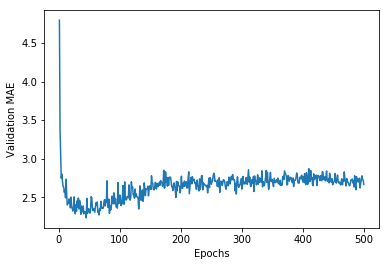

In [26]:
# Plotting the history (mean value for all folds)
import matplotlib.pyplot as plt
plt.plot(range(1, len(average_mae_history) + 1), 
         average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

## Smothing the curve with exponential moving average

In [27]:
# First 10 points have much higher value thus the visibility is limited
def smooth_curve(points, factor=0.9):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

In [28]:
smooth_mae_history = smooth_curve(average_mae_history[10:])

In [29]:
smooth_mae_history

[2.4918291132048807,
 2.5159141672719825,
 2.5158229050305811,
 2.5041444229938019,
 2.4968354443927807,
 2.4893557827327277,
 2.4882792499980266,
 2.4841240802018487,
 2.4718552136357523,
 2.4748831861953269,
 2.4659483787279672,
 2.4547826358968043,
 2.4412555581614788,
 2.4311705897186302,
 2.4384333310711601,
 2.4279921132476701,
 2.4136039370593245,
 2.4123261671703449,
 2.4029359107373791,
 2.4078484122714983,
 2.404161445298632,
 2.4126859022120692,
 2.4061478677423986,
 2.4115193741801808,
 2.4129788192654833,
 2.3995723612536275,
 2.3982575687710224,
 2.3912984638349744,
 2.3832182268718003,
 2.3834290050831739,
 2.3735515391591435,
 2.3668676269751563,
 2.3613689505135183,
 2.3560330388014195,
 2.3435202031060602,
 2.3575964368757449,
 2.3506862088020433,
 2.3489106105355533,
 2.3491008655848473,
 2.3463204246690306,
 2.3409131864524482,
 2.3394619077280101,
 2.3562300296408072,
 2.3699157932636723,
 2.3698568982266521,
 2.3654906464809509,
 2.364123406533523,
 2.360717413758

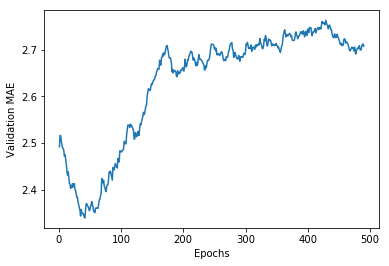

In [30]:
# Plotting the function (smoothed)
plt.plot(range(1, len(smooth_mae_history) + 1), smooth_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

In [31]:
# Iteration after which the mean absolute error is lowest
min_mae_error_iter = np.array(smooth_mae_history).argmin()
print(min_mae_error_iter)

41


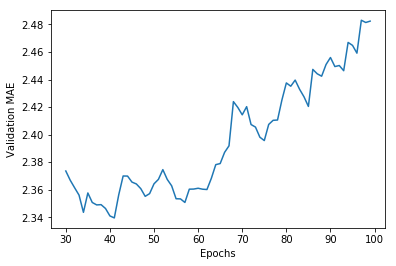

In [32]:
# Plotting the function (smoothed) only part between 30 and 100
plt.plot(range(30, 100), smooth_mae_history[30:100])
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

## Training the final model

In [33]:
from keras import backend as K

# Some memory clean-up
K.clear_session()

In [34]:
model = build_model()
model.fit(train_data, 
          train_targets,
          epochs = 80, 
          batch_size = 16, 
          verbose = 1)
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)

Epoch 1/80
404/404 [==============================] - 0s - loss: 488.9382 - mean_absolute_error: 20.2068     
Epoch 2/80
404/404 [==============================] - 0s - loss: 301.2433 - mean_absolute_error: 15.1075     
Epoch 3/80
404/404 [==============================] - 0s - loss: 133.8663 - mean_absolute_error: 9.2199     
Epoch 4/80
404/404 [==============================] - 0s - loss: 60.7304 - mean_absolute_error: 5.9218     
Epoch 5/80
404/404 [==============================] - 0s - loss: 39.0962 - mean_absolute_error: 4.6488     
Epoch 6/80
404/404 [==============================] - 0s - loss: 29.9844 - mean_absolute_error: 4.0176     
Epoch 7/80
404/404 [==============================] - 0s - loss: 25.1362 - mean_absolute_error: 3.5857     
Epoch 8/80
404/404 [==============================] - 0s - loss: 21.8742 - mean_absolute_error: 3.3603     
Epoch 9/80
404/404 [==============================] - 0s - loss: 19.7995 - mean_absolute_error: 3.1201     
Epoch 10/80
404/404 [==

404/404 [==============================] - 0s - loss: 6.0703 - mean_absolute_error: 1.7362     
Epoch 77/80
404/404 [==============================] - 0s - loss: 6.2447 - mean_absolute_error: 1.7257     
Epoch 78/80
404/404 [==============================] - 0s - loss: 5.9295 - mean_absolute_error: 1.7015     
Epoch 79/80
404/404 [==============================] - 0s - loss: 6.1180 - mean_absolute_error: 1.7791     
Epoch 80/80
 32/102 [========>.....................] - ETA: 0s

In [35]:
test_mae_score

2.6851870499405206